# Práctica 7 - Regresión lineal 

## Tratamiento de datos masivos - Rafael Caballero


Por favor, escribe tu nombre a continuación


Jorge Sánchez-Barriga Pons


### Introducción
Vamos a partir del fichero con las calificaciones de las pruebas PISA a estudiantes por país para intentar establecer **regresiones lineales**, es decir ser capaces de predecir un datos como combinación lineal de otros. 

Las columnas de este conjunto son:

```
RPC,PAIS,MAT,MAT_FE,MAT_MA,REA,REA_FE,REA_MA,SCI,SCI_FE,SCI_MA
```

RCP: Renta per cápita del país.
PAIS: Nombre del país.
MAT: Nota del país en matemáticas
MAT_FE: Nota del país en matemáticas para chicas
MAT_MA: Nota del país en matemáticas para chicos.

El resto son iguales pero lectura (REA) y ciencias (SCI). La pregunta que nos hacemos es ¿Podemos deducir por ejemplo, la nota en matemáticas de un país a partir de su nota en ciencia y lectura?


### Esquema general


Antes de empezar recordemos el esquema general del tratamiento de datos en aprendizaje automática:


0.- Cargar y preparar los datos 

1.- Preparar el regresor/clasificador.

2.- Aplicarlo con *fit* al conjunto de entrenamiento, lo que genera un modelo.

3.- Aplicar el modelo al conjunto que queramos con *transform*. Esto sirve tanto para predecir el resultado de nuevos valores como para evaluar el modleo obtenido en el paso 2.





### setup

In [1]:
%matplotlib inline
import os
# cambiamos las variables del sistema
spark = 'C:\\hlocal\\tdm\\spark\\hadoop\\spark-2.3.2-bin-hadoop2.7'
# en el path se añade
path = os.environ.get('PATH') 
path = path+ ';'+spark+'\\bin;'
os.environ['PATH'] = path
os.environ['SPARK_HOME']= spark 
os.environ['HADOOP_HOME']= spark 
os.environ['PYSPARK_DRIVER_PYTHON']= 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']='notebook'

# si da problema con collect quizás haya que poner java_home
#os.environ['JAVA_HOME']= 'C:\\Program Files\\Java\\jdk1.8.0_151'
labs = 'C:\\JDK\\jdk8-64bits'
os.environ['JAVA_HOME']= labs
os.environ['PATH'] = os.environ.get('JAVA_HOME')+'\\bin;'+path


import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
print("Preparado!!")


Preparado!!


### 0.- Lectura y preprocesado

1.- Para empezar leemos el fichero como un dataframe, recordando que es un fichero .csv con cabecera y que Spark debe inferir automáticamente el esquema. El dataframe resultado debe llamarse *raw*

In [4]:

## Solución
path = 'c:/hlocal/tdm/PisaRPP.csv'
raw = spark.read.format("com.databricks.spark.csv")\
            .options(header='true', inferschema='true') \
            .load(path)


In [5]:
# para comprobar que está bien podemos ejecutar este código y examinar el resultado
raw.describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
RPC,64,37946.421875,23786.070878458875,5998,128702
PAIS,64,None,None,Albania,Vietnam
MAT,64,457.90003437499996,51.0110372471199,327.702,564.1897
MAT_FE,64,455.5618782766279,49.96876447286404,329.745930838674,564.254533844227
MAT_MA,64,460.28304587737546,52.33950632120393,325.586561113527,564.12900352855
REA,64,459.964196875,48.05284131985104,346.549,535.1002
REA_FE,64,474.92981961948334,47.392871168080006,353.277295651411,550.511163985695
REA_MA,64,445.0736252631914,49.836431424287404,335.185435908668,525.315266235515
SCI,64,463.6992656249999,47.34237638410934,331.6388,555.5747


El siguiente código hace una gráfica de una muestra de los valores (en este caso como son muy pocos, la muestra los tomará todos, pero en general no será así), para hacernos una idea de si se sigue una relación lineal.

No handles with labels found to put in legend.


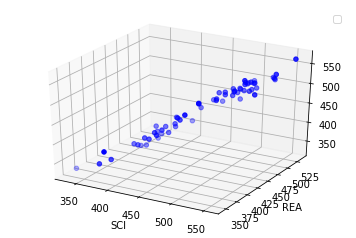

No handles with labels found to put in legend.


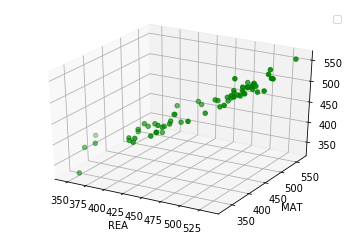

No handles with labels found to put in legend.


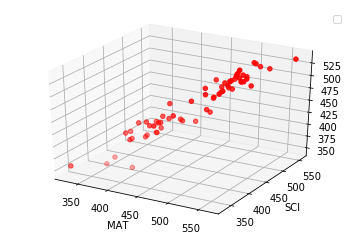

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Función que muesstra una gráfica a partir de una muestra. Parámetros
# datos: el dataframe
# x: el nombre de la columna x
# y: el nombre de la columna y
# puntos: el número de puntoss a mostrar
# color: de los puntos
def grafica(datos,x,y,z, puntos=100, color='darkgreen'):
    
    
    d = datos.select([x,y,z])
    n = datos.count()
    if n<puntos:
        p = 0.99 # seleccionar  casi todos
    else: 
        p = puntos / n
    valores = d.sample(False,p).sort(x).collect()

    # mostrar
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    x_v= list(map(lambda x:x[0],valores))
    y_v=list(map(lambda x:x[1],valores))
    z_v=list(map(lambda x:x[2],valores))
    ax.scatter(x_v,y_v,z_v, color=color)
    plt.xlabel(x) 
    plt.ylabel(y)
    plt.legend()
    plt.show()
   

### Mostramos renta per capita y cada uno de los 3 valores principales
grafica(raw,'SCI', 'REA','MAT', color='blue')
grafica(raw,'REA','MAT','SCI',color='green')
grafica(raw,'MAT','SCI','REA',color='red')
    


Aunque no se ve muy claro parece que al menos "podría ser". Antes del siguiente paso, debemos separar las columnas en dos: la que queremos predecir ('MAT') y un vector de features con las que usaremos para la predicción 'SCI' y 'REA'. 

In [22]:
from pyspark.ml.feature import VectorAssembler
# genera un vector a partir de los valores X
assembler = VectorAssembler(
        inputCols=['SCI','REA'],
        outputCol='features')

datosprep =  assembler.transform(raw)
datosprep = datosprep.select(['MAT','features'])

print(datosprep)

DataFrame[MAT: double, features: vector]


2.- El siguiente paso es separar el conjunto *datosprep* en dos:  entrenamiento (70%) y prueba (30%). Al dataframe de entrenamiento lo llamaremos *train* y al de prueba *test*. 


 


In [9]:
# solución 
splits = datosprep.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1]
display(train.select('MAT','features'))

DataFrame[MAT: double, features: vector]

### 1.- Preparar el regresor

3.- Ahora nos declaramos una variable con nombre *regresor* de tipo *LinearRegression*. Al crearla nos interesan 
algunos parámetros:
    
* *featuresCol*: nombre del vector de features. En nuestro ejemplo como se llama precisamente *features*, no hace falta.   
* *labelCol*: nombre de la columna con la variable depedendiente, en este caso 'MAT'
* *maxIter*: máximo número de iteraciones, de momento podemos ponerlo a 10
* *regParam*: parámetro de regularización, para evitar sobreajuste. Podemos poner por ejemplo a 0.1


In [10]:
from pyspark.ml.regression import LinearRegression
# solucion
regresor = LinearRegression(maxIter=10, regParam=0.1, labelCol='MAT')

### 2 y 3 .- Aplicar el regresor 

4.- Usar primero *fit* para obtener el modelo (guardarlo en una variable model_rl) sobre el conjunto de entrenamiento

In [12]:
# Solución
model_rl = regresor.fit(train)

5.- Aplicar el modelo al conjunto de test mediante el método *transform*, guardando el resultado en una variable *res_test*.

In [13]:
# Solución
res_test = model_rl.transform(test)

In [14]:
# para echar un vistazo al resultado podemos ejecutar este código
res_test.show()


+--------+-------------------+------------------+
|     MAT|           features|        prediction|
+--------+-------------------+------------------+
|359.6062|[375.7451,349.8593]| 364.9977526034738|
|403.8332|[411.1315,401.2881]|  402.686315371864|
|409.0333|[432.2262,425.3031]| 424.8352816402903|
| 413.157| [427.225,405.2588]|418.89692386046994|
|419.6635|[427.9978,416.2293]| 420.1915570820674|
| 420.454|[425.4895,428.3351]| 418.2743461741745|
|427.4827|[436.7311,433.5423]| 429.7142852111633|
|446.1098|[442.9475,430.5782]|435.76053338727803|
|453.6299|[454.8288,467.0395]|449.33392300082056|
|476.8309|[476.7475,469.5233]| 471.2720931313588|
|482.3051| [490.225,487.7581]| 485.5616331942136|
|488.0332|[473.2301,481.5255]| 468.3454006311183|
|492.4785|[509.2215,497.9719]|504.96102843147116|
|493.9181|[493.4224,500.1556]| 489.3381974058992|
|511.0769|[530.6612,526.4247]| 527.6659403361905|
|512.2528|[508.5748,502.9591]| 504.5560834831989|
|564.1897|[555.5747,535.1002]| 552.8818192388009|


### Medida del error

6.- Para poder medir el error del método, utilizaremos un *RegressionEvaluator*. Crear una variable evalua_rl que se obtenga mediante una llamada a la constructora *RegressionEvaluator(...)*, teniendo en cuenta los siguientes parámetros:

* predictionCol: nombre de la columna que contiene la predicción, que en este caso es "prediction"
                   
* labelCol: columna con el valor real 

* metricName: La medida de error, que puede ser "r^2", "mae" o "rmse". En este caso tomar el coeficiente de correlación "r2". Recordemos que cuanto más cercano a 1 mayor será el ajuste.

Para obtener el resultado bastará con llamar al método *evaluate* del evaluador, pasándole como parámetro el dataframe con las predicciones (*res_test*). Mostrar el coeficiente obtenido por pantalla (debe estar alrededor de 0.90)

In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
#Solucion
evalua_rl = RegressionEvaluator(predictionCol="prediction", labelCol='MAT',metricName='r2')

e =  evalua_rl.evaluate(res_test)

print(e)

0.9641836685443462


7.- [2 puntos] El fichero *sinmat.csv* contiene datos de REA y SCI para  países (imaginarios) de los que no se pudo hacer la prueba de matemáticas. Queremos predecirla con nuestro modelo.
Carga el fichero, que quedará en un dataframe almacenado en una variable *sinmat* y predice el resultado de la prueba mat para cada país. El resultado con las predicciones quedará en un dataframe 'conmat'. Por supuesto se puede (y debe) utilizar el modelo del ejercicio 5.

In [42]:
#pathsm = 'C:/hlocal/tdm/sinmat.csv'
# 7 Solución
pathsm = 'C:/hlocal/tdm/sinmat.csv'
sinmat = spark.read.format("com.databricks.spark.csv")\
            .options(header='true', inferschema='true') \
            .load(pathsm)

assembler = VectorAssembler(
        inputCols=['REA','SCI'],
        outputCol='features')

datos =  assembler.transform(sinmat)
conmat = model_rl.transform(datos)

In [43]:
# Ejecutar si se quiere echar un vistazo al resultado
conmat.show()

+---+---+-------------+------------------+
|REA|SCI|     features|        prediction|
+---+---+-------------+------------------+
|327|346|[327.0,346.0]|316.28905705396926|
|327|347|[327.0,347.0]| 316.3369436877578|
|327|348|[327.0,348.0]| 316.3848303215464|
|327|349|[327.0,349.0]|316.43271695533497|
|327|350|[327.0,350.0]| 316.4806035891236|
|327|351|[327.0,351.0]| 316.5284902229122|
|327|352|[327.0,352.0]|316.57637685670073|
|327|353|[327.0,353.0]|316.62426349048934|
|327|354|[327.0,354.0]|316.67215012427795|
|327|355|[327.0,355.0]| 316.7200367580665|
|327|356|[327.0,356.0]| 316.7679233918551|
|327|357|[327.0,357.0]|316.81581002564366|
|327|358|[327.0,358.0]|316.86369665943226|
|327|359|[327.0,359.0]| 316.9115832932209|
|327|360|[327.0,360.0]| 316.9594699270094|
|327|361|[327.0,361.0]|317.00735656079803|
|327|362|[327.0,362.0]|317.05524319458664|
|327|363|[327.0,363.0]| 317.1031298283752|
|327|364|[327.0,364.0]| 317.1510164621638|
|327|365|[327.0,365.0]|317.19890309595235|
+---+---+--

Si se quiere probar el resultado, se puede ejecutar el siguiente bloque, que debe mostrar un plano inclinado:

No handles with labels found to put in legend.


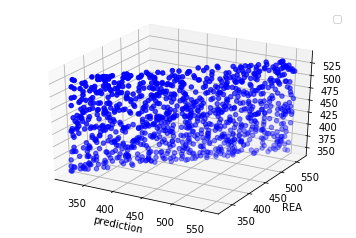

In [44]:
grafica(conmat,'prediction', 'REA','SCI', puntos=1000, color='blue')

9.- [2 puntos] Queremos ahora intentar predecir la renta per capita (columna RPC) a partir del resto menos PAIS (que es alfanumérica y no puede usarse). Escribir en el siguiente bloque el código para obtener el coeficiente de correlación lineal r^2 a partir del dataframe *raw* obtenido en el ejercicio 1. El código, al final, debe escribir el correspondiente valor de r^2. Nos saldrá que NO es una buena idea usar regresión lineal para este propósito.

In [49]:
# Solución
assembler = VectorAssembler(
        inputCols=['SCI','REA','MAT','MAT_FE','MAT_MA','REA_FE','REA_MA','SCI_FE','SCI_MA'],
        outputCol='features')

datosprep =  assembler.transform(raw)
datosprep = datosprep.select(['RPC','features'])

splits = datosprep.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1]

regresor = LinearRegression(maxIter=10, regParam=0.1, labelCol='RPC')

model_rl = regresor.fit(train)
res_test = model_rl.transform(test)

res_test.show()

evalua_rl = RegressionEvaluator(predictionCol="prediction", labelCol='RPC',metricName='r2')

e =  evalua_rl.evaluate(res_test)

print(e)


+-----+--------------------+------------------+
|  RPC|            features|        prediction|
+-----+--------------------+------------------+
| 5998|[427.9978,416.229...| 31610.57158795203|
|11481|[411.1315,401.288...| 51879.95450520431|
|12186|[386.4034,361.055...|1095.6859826701257|
|13162|[403.0997,397.259...| 23383.45446922758|
|13274|[427.225,405.2588...|30534.339891051146|
|17669|[419.608,427.4875...|19617.752857753105|
|18116|[331.6388,357.737...|  15627.3911778248|
|18681|[411.3136,426.884...| 44351.46658961523|
|23571|[435.363,436.5721...|23482.400875695836|
|25667|[446.9561,458.570...|24985.994925696898|
|28346|[425.4895,428.335...| 34456.97098296753|
|29057|[454.8288,467.039...| 55558.37301065927|
|29489|[490.225,487.7581...| 51086.54615743329|
|33842|[534.1937,519.142...|52318.601311101025|
|36566|[512.8636,505.215...|60290.202925291596|
|37673|[466.5528,478.960...| 46834.89626008521|
|44670|[464.7819,446.666...|  53740.5247906704|
|46342|[530.6612,526.424...| 68577.56827

**Entrega: Recordar subir el notebook al campus virtual ¡gracias!**

In [ ]:
'''
# solo por curiosidad: creacion de sinmat.csv
f = 10
with open('c:/hlocal/tdm/sinmat.csv', mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL, lineterminator="\n")
    csv_writer.writerow(['REA', 'SCI'])
    for rea in range(327*f,565*f):
        for sci in range(346*f,536*f):
           csv_writer.writerow([str(rea/f), str(sci/f)])
'''